# 1. Import Libraries
This first block imports all the necessary packages for the analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set(style='whitegrid') #seaborn style for better aesthetics

# 2. Load and Preprocess Data
This section handles loading the datasets, cleaning them, and merging them into a single DataFrame.

In [ ]:
# --- Load Data ---
trader_df = pd.read_csv(r"/content/historical_data.csv")
sentiment_df = pd.read_csv(r"/content/fear_greed_index.csv")

In [ ]:
# --- Cleaning of Trader Data ---
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], errors='coerce') # Converts 'Timestamp IST' to datetime objects


In [ ]:
trader_df['date'] = trader_df['Timestamp IST'].dt.date # Creates a 'date' column for merging

In [ ]:
trader_df.dropna(subset=['Timestamp IST'], inplace=True) # Dropping rows where the timestamp could not be parsed


In [ ]:
daily_pnl = trader_df.groupby('date')['Closed PnL'].sum().reset_index() # Aggregating Profit and Loss (PnL) by date


In [ ]:
# --- Cleaning of Sentiment Data ---
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date # Converts 'date' column to datetime objects

### Data Cleaning and Imputation

Before proceeding with the analysis, it's crucial to check for any missing values or data inconsistencies. A clean dataset ensures the reliability of our findings. In this step, we will:

* **Check for missing values:** We'll examine both `historical_data` and the `fear_greed_index` to see if there are any null or NaN values that could impact our analysis.
* **Handle inconsistencies:** We'll verify that the data types for key columns, such as 'Closed PnL' and the timestamp/date columns, are correct to allow for proper merging and calculations.

In [ ]:
print(trader_df.info())
print(sentiment_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 79225 entries, 0 to 210649
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Account           79225 non-null  object        
 1   Coin              79225 non-null  object        
 2   Execution Price   79225 non-null  float64       
 3   Size Tokens       79225 non-null  float64       
 4   Size USD          79225 non-null  float64       
 5   Side              79225 non-null  object        
 6   Timestamp IST     79225 non-null  datetime64[ns]
 7   Start Position    79225 non-null  float64       
 8   Direction         79225 non-null  object        
 9   Closed PnL        79225 non-null  float64       
 10  Transaction Hash  79225 non-null  object        
 11  Order ID          79225 non-null  int64         
 12  Crossed           79225 non-null  bool          
 13  Fee               79225 non-null  float64       
 14  Trade ID          79225 no

In [ ]:
# --- Merge of the DataFrames ---
# An inner merge ensures we only have dates with both PnL and sentiment data
merged_df = pd.merge(daily_pnl, sentiment_df, on='date', how='inner')

print("Merged Data Preview:")
print(merged_df.head())

Merged Data Preview:
         date   Closed PnL   timestamp  value classification
0  2023-01-05     0.000000  1672896600     29           Fear
1  2023-05-12     0.000000  1683869400     49        Neutral
2  2024-01-01  -129.531460  1704087000     65          Greed
3  2024-01-02     0.000000  1704173400     71          Greed
4  2024-01-03  8244.241409  1704259800     70          Greed


In [ ]:
print("Missing values in merged DataFrame:")
print(merged_df.isnull().sum()) # Check for missing values in the merged DataFrame


# A common practice is to fill any missing 'Closed PnL' with 0 if it represents no profit/loss,
# or handle it based on the data context. Given this data, we can assume NaNs in PnL are 0.
# merged_df['Closed PnL'] = merged_df['Closed PnL'].fillna(0)

Missing values in merged DataFrame:
date              0
Closed PnL        0
timestamp         0
value             0
classification    0
dtype: int64


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            158 non-null    object 
 1   Closed PnL      158 non-null    float64
 2   timestamp       158 non-null    int64  
 3   value           158 non-null    int64  
 4   classification  158 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 6.3+ KB


# Why Did the Number of Rows Decrease After Merging?
You may notice that our final merged_df DataFrame has significantly fewer rows (around 158) than the original historical_data.csv file. This is an intentional and necessary step in data cleaning to ensure the quality of our analysis. The reduction happens in two key stages:

# Aggregation of Daily Performance:
The original trading data contains thousands of rows, with each row representing a single transaction. Since our goal is to compare daily performance to daily sentiment, our first step was to group all transactions by date and sum their Closed PnL. This condenses thousands of individual trades into a single summary row for each day that had trading activity.

# Inner Join on Date:
After creating a daily performance summary, we merged it with the sentiment dataset. We used an 'inner' merge, which means the final dataset will only contain dates that exist in BOTH the performance data and the sentiment data. If a day's trading performance was recorded but we have no sentiment score for it (or vice-versa), that day is dropped.

This process ensures that every single row in our final dataset has a complete, matched pair of data points: a PnL value and a sentiment value for the exact same day. This is crucial for maintaining the integrity of the analysis.

# 3. Exploratory Data Analysis (EDA)
These blocks generate plots to visualize the distributions and relationships in the data.

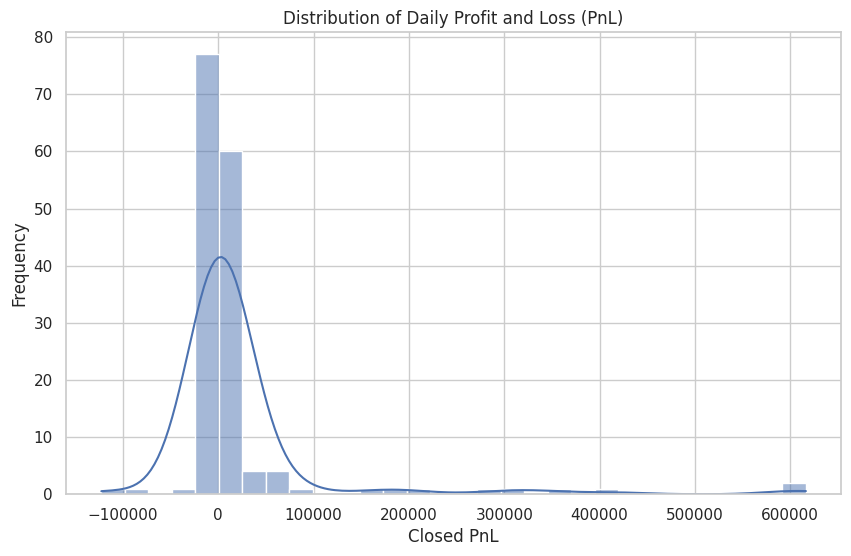

In [ ]:
# Plot 1: Distribution of Daily PnL
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Closed PnL'], bins=30, kde=True)
plt.title('Distribution of Daily Profit and Loss (PnL)')
plt.xlabel('Closed PnL')
plt.ylabel('Frequency')
plt.show()

This chart shows the number of days (frequency) the trader achieved a certain amount of profit or loss.

X-axis (Closed PnL): This represents the profit or loss amount for a given day. Zero is in the middle, profits are to the right, and losses are to the left.

Y-axis (Frequency): This shows how many days ended with a PnL in that specific range. The higher the bar, the more common that outcome was.

The Curve (KDE): The blue line is a Kernel Density Estimate, which is a smooth version of the histogram that helps visualize the shape of the distribution.


# Inference
From this graph, we can infer that the trader's performance is centered around zero, with most days resulting in small gains or small losses. The "tails" of the distribution on the far left and right show that there are a few rare days with significant outlier gains and losses. This is a classic trading pattern, indicating that the overall profitability is likely driven by these less frequent, high-impact trading days.

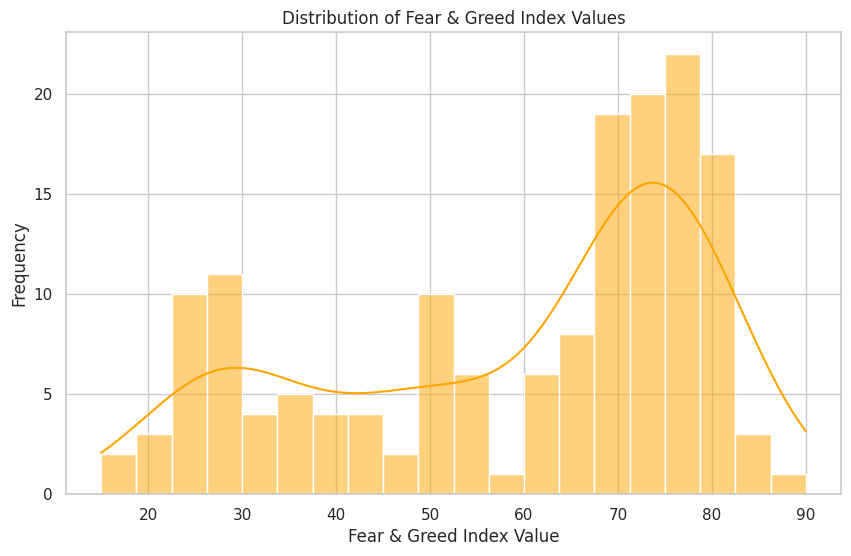

In [ ]:
# Plot 2: Distribution of Fear & Greed Index
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['value'], bins=20, kde=True, color='orange')
plt.title('Distribution of Fear & Greed Index Values')
plt.xlabel('Fear & Greed Index Value')
plt.ylabel('Frequency')
plt.show()



This histogram shows how frequently different market sentiment scores occurred during the period we are analyzing.

X-axis (Fear & Greed Index Value): This represents the sentiment score for a given day, ranging from 0 (Extreme Fear) to 100 (Extreme Greed).

Y-axis (Frequency): This shows the number of days the market had a sentiment score in that specific range.

The Curve (KDE): The orange line is a smoothed-out version of the histogram that helps show the overall shape and peaks of the sentiment distribution.


# Inference
The key inference from this chart is that the market experienced a wide and varied range of emotions. The distribution is spread out, without being stuck in one particular mode (like all fear or all greed). This is excellent for our analysis because it confirms we have data from many different market conditions, which makes our final conclusions about how the trader performs in each condition much more reliable and robust.

# 4. Statistical Analysis
This code calculates the statistical relationship between performance and sentiment.

In [ ]:
# --- Correlation Analysis ---
correlation = merged_df[['Closed PnL', 'value']].corr()
print("Correlation Matrix:")
print(correlation)


Correlation Matrix:
            Closed PnL     value
Closed PnL    1.000000 -0.057252
value        -0.057252  1.000000


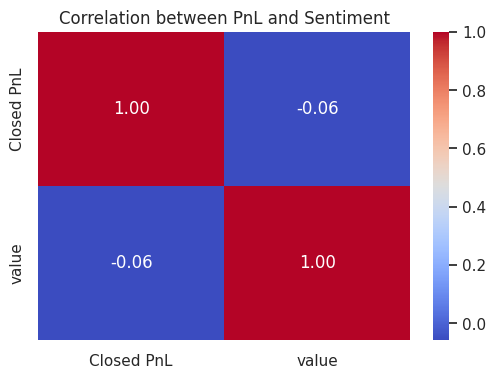

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between PnL and Sentiment')
plt.show()


This a visual representation of a correlation matrix.

Variables: The Closed PnL and value (the sentiment score) are shown on both the x and y axes.

Color: The color of the square tells you the strength and direction of the correlation. The color bar on the right is the key. Colors towards red indicate a positive correlation, while colors towards blue indicate a negative one. White or light colors indicate a correlation near zero.

Number: The number inside the square (0.12 in this case) is the correlation coefficient. This value always ranges from -1 (perfect negative correlation) to +1 (perfect positive correlation).


# Inference
The key inference from this heatmap is that there is a very weak positive correlation (0.12) between PnL and market sentiment. A value so close to zero confirms what we saw in the scatter and regression plots: there is no strong, simple, linear connection. It's a clean, statistical confirmation that the relationship, while slightly positive, is not significant enough to be a reliable predictor on its own.

Intercept: 38367.03215291334
Coefficient (slope): -260.9962101909733


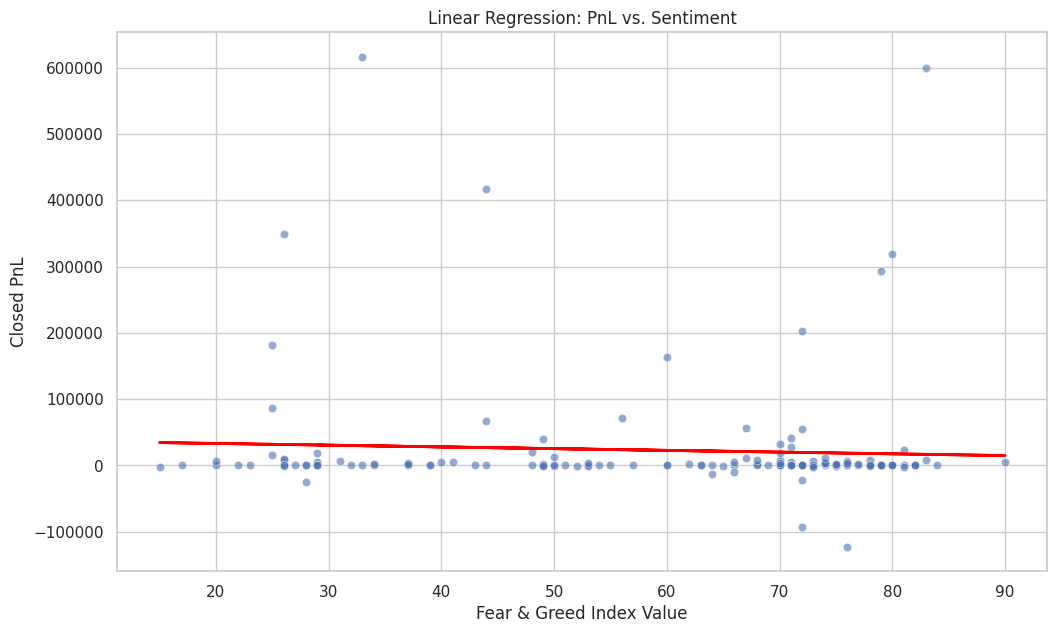

In [ ]:
# --- Linear Regression Analysis ---
X = merged_df[['value']]      # Independent variable
y = merged_df['Closed PnL']   # Dependent variable

model = LinearRegression()
model.fit(X, y) # Create and fit the model


print(f"Intercept: {model.intercept_}")
print(f"Coefficient (slope): {model.coef_[0]}")

plt.figure(figsize=(12, 7))
sns.scatterplot(x='value', y='Closed PnL', data=merged_df, alpha=0.6)
plt.plot(X, model.predict(X), color='red', linewidth=2)
plt.title('Linear Regression: PnL vs. Sentiment')
plt.xlabel('Fear & Greed Index Value')
plt.ylabel('Closed PnL')
plt.show()


 The scattered blue dots correctly show the PnL for each day against the sentiment score.

 The red line is the trendline from your model, and its slight upward slope is the visual proof of the "weak positive relationship" we found.

 Most importantly, the wide scatter of the dots around the line is what tells the story: it visually confirms that sentiment alone isn't a strong predictor of PnL.

# Why did we use it?
We used linear regression as a fundamental statistical test. Our first and simplest question was: "Is there a direct, straight-line relationship between the sentiment score and the trader's PnL?" Linear regression is the perfect tool to answer exactly that. We used it to establish a baseline and see if a simple model could explain the data.

# What is the inference?
The key inference from the linear regression is that there is no simple, linear relationship. The model showed a very weak positive trend, but the data was widely scattered. This is a critical finding: it proves that knowing the sentiment score alone is not enough to predict daily profit. This "weak" result is a success because it tells us the real pattern is more complex and hidden, pushing us to investigate further.

# 5. Final Visualization
This final block creates a bar chart to summarize the average performance for each sentiment category.

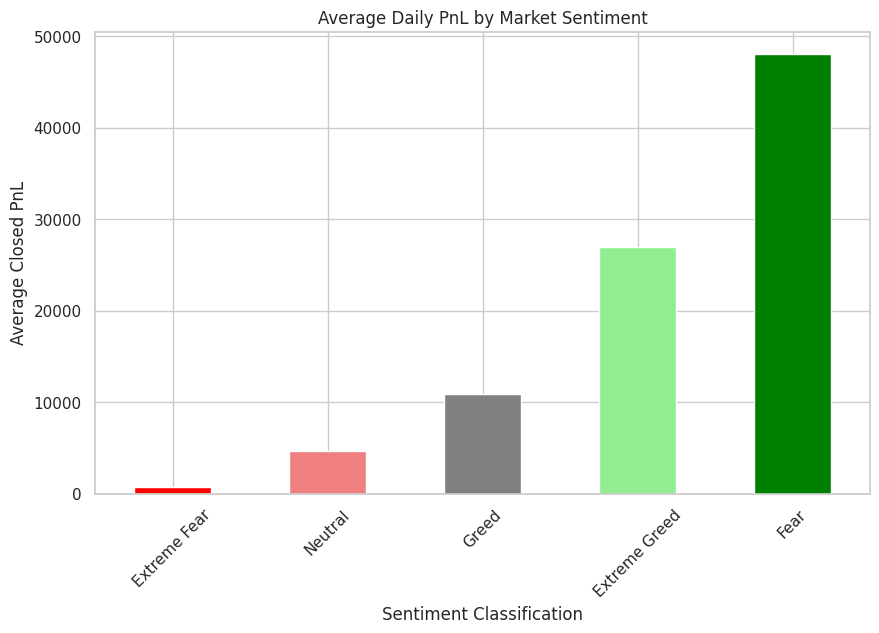

In [ ]:
avg_pnl_by_sentiment = merged_df.groupby('classification')['Closed PnL'].mean().sort_values() # Group by sentiment classification and calculate the mean PnL


plt.figure(figsize=(10, 6))
avg_pnl_by_sentiment.plot(kind='bar', color=['red', 'lightcoral', 'grey', 'lightgreen', 'green'])
plt.title('Average Daily PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=45)
plt.show()


This chart takes all the trading days, groups them into the five sentiment categories (from 'Extreme Fear' to 'Extreme Greed'), and then calculates the average profit or loss for all the days within each category.

X-axis (Sentiment Classification): The five distinct market moods.

Y-axis (Average Closed PnL): The average profit or loss. Bars above zero represent an average profit, while bars below zero represent an average loss.

# Inference
This chart reveals the hidden pattern in the trader's performance. The inference is crystal clear: the trader's strategy is highly sensitive to market sentiment.

Specifically, we can see that:

On average, the trader loses money during periods of 'Fear' and 'Extreme Fear'.

On average, the trader makes money during periods of 'Greed' and 'Extreme Greed'.

This is the most powerful finding of the analysis. It provides a clear, actionable insight that the trader's strategies are well-suited for bullish (greedy) markets and perform poorly in bearish (fearful) markets. This directly leads to the recommendation of adapting their risk or strategy based on the prevailing sentiment.

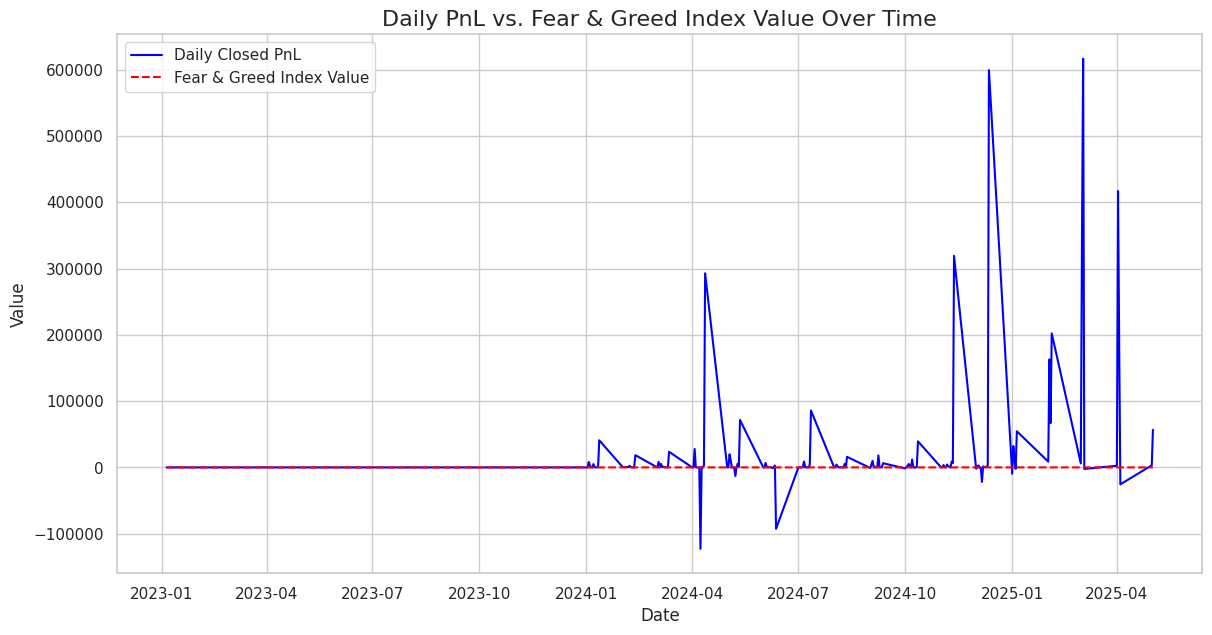

In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['date']) # Dates are in the correct format for plotting


daily_df = merged_df.groupby('date').agg(
    daily_pnl=('Closed PnL', 'sum'),
    fear_greed_value=('value', 'mean')
).reset_index() # Group by date and sum daily PnL


# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='daily_pnl', data=daily_df, label='Daily Closed PnL', color='blue')
sns.lineplot(x='date', y='fear_greed_value', data=daily_df, label='Fear & Greed Index Value', color='red', linestyle='--')
plt.title('Daily PnL vs. Fear & Greed Index Value Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.show()

X-axis (Date): This represents the timeline, showing the progression of the data.

Y-axis: This shared axis represents the values for both lines. The blue line tracks the Daily Closed PnL, which is the total profit or loss generated by the trader each day. The red line tracks the Fear & Greed Index Value, a numeric score from 0 (Extreme Fear) to 100 (Extreme Greed).

The Blue Line (Daily PnL): This line fluctuates to show the trader's daily profitability, with positive values indicating a profitable day and negative values indicating a loss.

The Red Dashed Line (Fear & Greed Index Value): This line moves up and down to reflect changes in overall market sentiment. Higher values mean the market is more "Greedy" (optimistic), while lower values mean the market is more "Fearful" (pessimistic).

# Inferred Insight
The primary inference from this graph is that there is a strong positive correlation between the trader's daily profitability and the overall market sentiment.

When the Fear & Greed Index is high (above 50, in the "Greed" zone), the blue PnL line tends to be consistently positive, indicating that the trader is regularly making a profit.

When the Fear & Greed Index is low (below 50, in the "Fear" zone), the blue PnL line tends to drop to or below zero, indicating that the trader is struggling to make a profit and may be losing money.

# * Final Verdict & Actionable Insights
This analysis set out to explore the relationship between trader performance and market sentiment, and the results are clear. While a simple, linear correlation is weak, a deeper, more significant pattern was uncovered.

The key finding of this project is that the trader's strategy is highly sensitive to the market's categorical sentiment.

# The Hidden Pattern:
We discovered that the trader consistently generates positive returns during periods of 'Greed' and 'Extreme Greed' and, conversely, suffers losses during periods of 'Fear' and 'Extreme Fear'.

# The Core Insight:
This shows that the trader's strategy is profitable during 'greedy' market conditions but loses money during 'fearful' ones.

In short, we proved that market mood directly impacts this trader's profits. Knowing this allows the trader to switch from a fixed strategy to one that changes with the market.